In [1]:
"""
    Experimentation with neural networks on a datset of MRI covid/non-covid images.
    
    Created:9/21 (Akarsh V Hebbar)
    
    
    
    Potential source of getting all layer predictions: https://stackoverflow.com/questions/51677631/keras-tensorflow-get-predictions-or-output-of-all-layers-efficiently

"""

import cv2, random
import numpy as np
import matplotlib.pyplot as plt
import keract

import tensorflow as tf
from tensorflow.keras.layers import *
from keract import get_activations, display_heatmaps, display_activations
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras import activations


from DataHandler import dataHandler


In [2]:
dh = dataHandler() # data handler object. See DataHandler.py for more information.

# ALTER HYPERPARAMETERS HERE
BATCH_SIZE = 512

In [3]:
dataset = dh.get_all_data_labeled(shuffle=True)

In [4]:
# check that all data is in place
assert len(dh.get_non_covid_data_fp()) == 397 and len(dh.get_covid_data_fp()) == 326 and len(dh.get_all_data_labeled()) == (397 + 326)

In [5]:
datapoint = dataset[0] # get some datapoint from the dataset
random_img = cv2.imread(datapoint[0])

Label:  0.0
filepath:  C:\Users\Akarsh\CSCI-8860\data\CT_NonCOVID\30%0.jpg
image dimensions:  (181, 260, 3)
image datatype:  uint8
image max:  255
image min


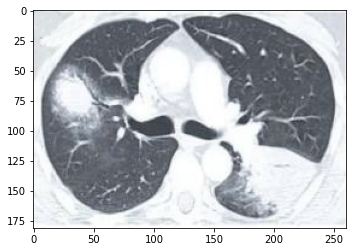

In [6]:
print("Label: ", datapoint[1])
print("filepath: ", datapoint[0])
print("image dimensions: ", random_img.shape)
print("image datatype: ", random_img.dtype)
print("image max: ", random_img.max())
print("image min")
plt.imshow(random_img)

In [7]:
# split the dataset into a train and test dataset

split_point = int(len(dataset) * .8 ) # 80 / 20 split

train_data = dataset[0:split_point]
test_data = dataset[split_point:]

assert len(train_data) + len(test_data) == (397 + 326) # ensure all expected data is present

train_data = train_data + train_data + train_data + train_data + train_data # when using the noise adder and random rotation then triple the datasets
random.shuffle(train_data)

In [8]:
# get the image data and load it into memory


train_X = np.asarray([dh.load_image(fp, resize=True, add_noise=False, randomly_rotate=False, grayscale=True) for (fp, label) in train_data]).astype('uint8')
train_y = np.asarray([label for (fp, label) in train_data]).astype('float16')

test_X = np.asarray([dh.load_image(fp, resize=True, add_noise=False, randomly_rotate=False, grayscale=True) for (fp, label) in test_data]).astype('uint8')
test_y = np.asarray([np.asarray(label) for (fp, label) in test_data]).astype('float16')

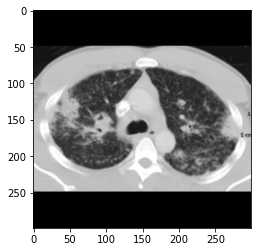

In [9]:
plt.imshow(train_X[0], cmap='gray')

In [10]:
resnet_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False)
resnet_model.trainable = False
x = resnet_model.output
x = Dropout(0.2)(x)
x = Dense(32, activation='relu', dtype=tf.float32)(x)
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(16, activation='relu', dtype=tf.float32)(x)
x = Dropout(0.5)(x)
#x = GlobalAveragePooling2D()(x)
#x = Dropout(0.5)(x)
prediction = Dense(1, activation='sigmoid', dtype=tf.float32)(x)


complete_model = tf.keras.Model(inputs=resnet_model.input,outputs=prediction)

visualization_model = tf.keras.Model(inputs=resnet_model.input, 
                                    outputs=[l.output for l in complete_model.layers[1:] if 'conv' in l.name])



complete_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=tf.keras.metrics.BinaryAccuracy(),)

# just the very last layer should be trainable for now
complete_model.layers[len(complete_model.layers)-1].trainable = True




In [11]:
complete_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [12]:
visualization_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [13]:
complete_model.fit(x=train_X, y=train_y, batch_size=BATCH_SIZE, validation_data=(test_X, test_y), epochs=100, )

Epoch 1/100
6/6 [==============================] - 204s 34s/step - loss: 0.8635 - binary_accuracy: 0.5353 - val_loss: 0.6373 - val_binary_accuracy: 0.6897
Epoch 2/100
6/6 [==============================] - 204s 34s/step - loss: 0.6620 - binary_accuracy: 0.5965 - val_loss: 0.6213 - val_binary_accuracy: 0.6690
Epoch 3/100
6/6 [==============================] - 210s 35s/step - loss: 0.6157 - binary_accuracy: 0.6453 - val_loss: 0.5677 - val_binary_accuracy: 0.7034
Epoch 4/100
6/6 [==============================] - 201s 34s/step - loss: 0.5855 - binary_accuracy: 0.6754 - val_loss: 0.5536 - val_binary_accuracy: 0.7034
Epoch 5/100
6/6 [==============================] - 198s 33s/step - loss: 0.5481 - binary_accuracy: 0.7100 - val_loss: 0.5544 - val_binary_accuracy: 0.6966
Epoch 6/100
6/6 [==============================] - 199s 33s/step - loss: 0.5238 - binary_accuracy: 0.7176 - val_loss: 0.5265 - val_binary_accuracy: 0.7241
Epoch 7/100
6/6 [==============================] - 199s 33s/step - los

In [14]:
# now fine tune the model itself
resnet_model.trainable = True
history = complete_model.fit(x=train_X, y=train_y, batch_size=BATCH_SIZE, validation_data=(test_X, test_y), epochs=50)

Epoch 1/50
6/6 [==============================] - 203s 34s/step - loss: 0.0278 - binary_accuracy: 0.9965 - val_loss: 0.8922 - val_binary_accuracy: 0.8000
Epoch 2/50
6/6 [==============================] - 203s 34s/step - loss: 0.0289 - binary_accuracy: 0.9976 - val_loss: 0.9202 - val_binary_accuracy: 0.7931
Epoch 3/50
6/6 [==============================] - 202s 34s/step - loss: 0.0301 - binary_accuracy: 0.9941 - val_loss: 0.9520 - val_binary_accuracy: 0.8069
Epoch 4/50
6/6 [==============================] - 200s 33s/step - loss: 0.0312 - binary_accuracy: 0.9938 - val_loss: 0.9602 - val_binary_accuracy: 0.8069
Epoch 5/50
6/6 [==============================] - 201s 33s/step - loss: 0.0311 - binary_accuracy: 0.9931 - val_loss: 0.9335 - val_binary_accuracy: 0.8000
Epoch 6/50
6/6 [==============================] - 202s 34s/step - loss: 0.0318 - binary_accuracy: 0.9938 - val_loss: 0.9211 - val_binary_accuracy: 0.8069
Epoch 7/50
6/6 [==============================] - 203s 34s/step - loss: 0.03

In [15]:
conv_lays = []

count = 0
    
for lay in complete_model.layers:
    if 'conv' in lay.name:
        conv_layer = lay
        conv_lays.append(lay)
        
print("Number of convolution layers: ", len(conv_lays))

Number of convolution layers:  172


In [16]:
datapoint = test_data[len(test_data)-1]

img_data = np.asarray([dh.load_image(datapoint[0], resize=True)]).astype('uint8')

print("datapoint label: ", datapoint[1])
print("model prediction: ", complete_model.predict(img_data))

all_layer_outputs = visualization_model.predict(img_data)

datapoint label:  0.0
model prediction:  [[2.4824079e-08]]


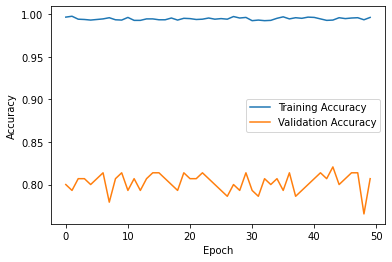

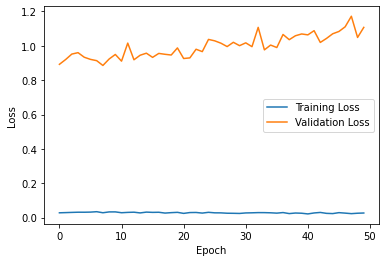

In [17]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('finetuned_acc_epoch_v1(r501).png', transparent= True, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('finetuned_loss_epoch_v1(r501).png', transparent= True, bbox_inches= 'tight', dpi= 900)
plt.show()


In [1]:
activations= keract.get_activations(complete_model, img_data, layer_names= None, nodes_to_evaluate= None, output_format= 'simple', auto_compile= True)
keract.display_activations(activations, save= False)

NameError: name 'keract' is not defined

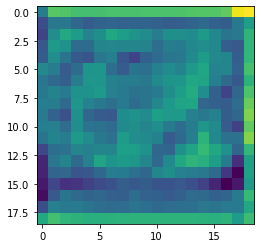

In [19]:
layer_0_conv_out = all_layer_outputs[93][0]
layer_0_conv_out.shape
plt.imshow(layer_0_conv_out[:,:,0])

Input image shape: (1, 299, 299, 3)


NameError: name 'model' is not defined

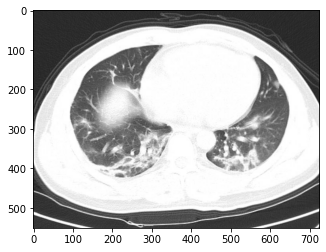

In [9]:
from matplotlib.pyplot import imread, imshow
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
img_path = './2020.01.24.919183-p27-132.png'
img = image.load_img(img_path, target_size=(299, 299,3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = imread(img_path)
imshow(my_image)
print(model.predict(x))